# PyTorch Deep Dive: Autograd and Gradients

Welcome to the "Engine Room" of PyTorch. 

In this notebook, we will learn how machines actually learn. But before we talk about mountains or hikers, we need to define the **Language of Learning**.

## Learning Objectives
- **The Vocabulary**: What is a "Loss Function" and "Learning Rate"?
- **The Intuition**: The "Blindfolded Hiker" analogy (Now that we know the terms).
- **The Mechanism**: The "Recording Tape" analogy (requires_grad).
- **The Math**: What exactly is a gradient? (Sensitivity).


In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(42)
print("PyTorch version:", torch.__version__)

PyTorch version: 2.3.0


## Part 1: The Vocabulary (Definitions First)

Before we can understand *how* AI learns, we need to agree on what "Learning" means.

### 1. The Loss Function (The Scorecard)
Imagine you are taking a test. You get a score of 80/100. Your "Error" is 20.
In AI, we call this "Error" the **Loss**.

- **High Loss** = The model is doing a bad job (e.g., calling a Cat a Dog).
- **Low Loss** = The model is doing a good job.
- **Goal**: Make the Loss as close to **0** as possible.

### 2. The Learning Rate (The Step Size)
When the model realizes it made a mistake, it needs to change its numbers (weights) to fix it.
But *how much* should it change them?

- **Learning Rate**: A tiny number (usually 0.01 or 0.001) that controls how big of a change we make.
- **Too Big**: You might overshoot the correct answer.
- **Too Small**: It will take forever to learn.

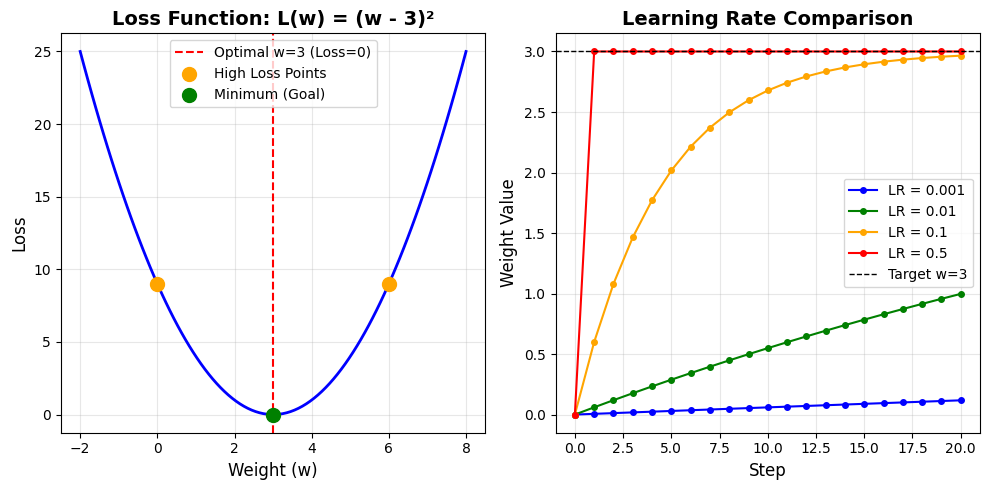

Key Observations:
• Left: The loss is lowest at w=3 (the parabola's bottom)
• Right: Small learning rates converge slowly, large ones may overshoot


In [2]:
# Visualize a simple quadratic loss function: L(w) = (w - 3)^2
w_values = np.linspace(-2, 8, 100)
loss_values = (w_values - 3) ** 2

plt.figure(figsize=(10, 5))

# Plot 1: Loss Function
plt.subplot(1, 2, 1)
plt.plot(w_values, loss_values, 'b-', linewidth=2)
plt.axvline(x=3, color='r', linestyle='--', label='Optimal w=3 (Loss=0)')
plt.scatter([0, 6], [9, 9], color='orange', s=100, zorder=5, label='High Loss Points')
plt.scatter([3], [0], color='green', s=100, zorder=5, label='Minimum (Goal)')
plt.xlabel('Weight (w)', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Function: L(w) = (w - 3)²', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Effect of Learning Rate
plt.subplot(1, 2, 2)
learning_rates = [0.001, 0.01, 0.1, 0.5]
colors = ['blue', 'green', 'orange', 'red']

for lr, color in zip(learning_rates, colors):
    w = 0.0
    trajectory = [w]
    for _ in range(20):
        gradient = 2 * (w - 3)  # derivative of (w-3)^2
        w = w - lr * gradient
        trajectory.append(w)
    plt.plot(trajectory, label=f'LR = {lr}', marker='o', markersize=4, color=color)

plt.axhline(y=3, color='black', linestyle='--', linewidth=1, label='Target w=3')
plt.xlabel('Step', fontsize=12)
plt.ylabel('Weight Value', fontsize=12)
plt.title('Learning Rate Comparison', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key Observations:")
print("• Left: The loss is lowest at w=3 (the parabola's bottom)")
print("• Right: Small learning rates converge slowly, large ones may overshoot")

### Visualization: What Does a Loss Function Look Like?

Let's visualize a simple loss function: Mean Squared Error (MSE) for a single parameter.

## Part 2: The Intuition (The Blindfolded Hiker)

Now that we know the terms, let's visualize them.

Imagine you are standing on a mountain at night. You are blindfolded. Your goal is to get to the very bottom of the valley.

- **The Mountain**: This is the **Loss Function**. High elevation means High Error. Low elevation means Low Error.
- **Your Location**: This represents the current **Parameters** (Weights) of your model.
- **The Slope**: This is the **Gradient**. It tells you which way is "Up".
- **The Step**: This is the **Learning Rate**. You take a step *opposite* to the slope to go down.

**The Algorithm (Gradient Descent):**
1. Feel the slope with your feet (Calculate Gradient).
2. Turn around to face downhill (Negative Gradient).
3. Take a small step (Learning Rate).
4. Repeat until you are at the bottom (Loss = 0).

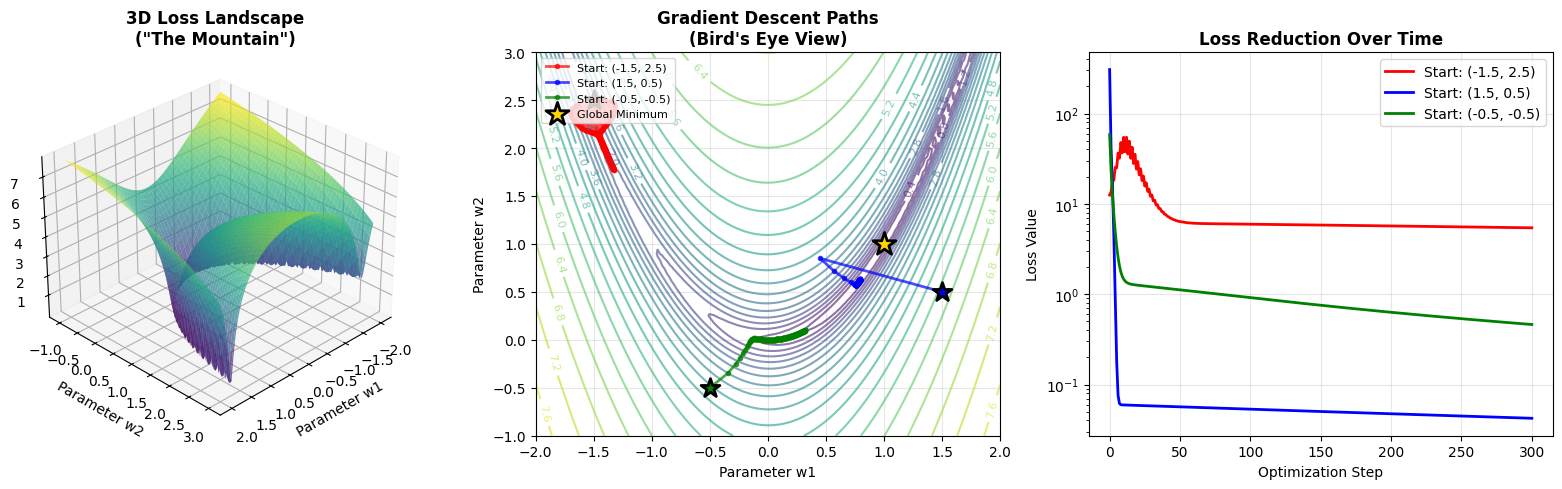

Interpretation:
• Left: The 3D surface shows the loss landscape - valleys are low loss
• Middle: Different starting points converge to the minimum (gold star)
• Right: Loss decreases exponentially as we 'walk down the mountain'


In [3]:
from mpl_toolkits.mplot3d import Axes3D

# Create a 2D loss landscape (Rosenbrock function - a classic optimization test)
def loss_function(x, y):
    return (1 - x)**2 + 100 * (y - x**2)**2

# Generate grid
x_range = np.linspace(-2, 2, 100)
y_range = np.linspace(-1, 3, 100)
X, Y = np.meshgrid(x_range, y_range)
Z = loss_function(X, Y)

# Gradient descent simulation
def gradient_rosenbrock(x, y):
    dx = -2 * (1 - x) - 400 * x * (y - x**2)
    dy = 200 * (y - x**2)
    return dx, dy

# Run gradient descent from different starting points
start_points = [(-1.5, 2.5), (1.5, 0.5), (-0.5, -0.5)]
paths = []

for start_x, start_y in start_points:
    x, y = start_x, start_y
    path = [(x, y)]
    lr = 0.001
    
    for _ in range(300):
        dx, dy = gradient_rosenbrock(x, y)
        x = x - lr * dx
        y = y - lr * dy
        path.append((x, y))
    
    paths.append(path)

# Create visualization
fig = plt.figure(figsize=(16, 5))

# 3D Surface Plot
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X, Y, np.log(Z + 1), cmap='viridis', alpha=0.7)
ax1.set_xlabel('Parameter w1')
ax1.set_ylabel('Parameter w2')
ax1.set_zlabel('Loss (log scale)')
ax1.set_title('3D Loss Landscape\n("The Mountain")', fontweight='bold')
ax1.view_init(elev=30, azim=45)

# Contour Plot with Gradient Descent Paths
ax2 = fig.add_subplot(132)
contour = ax2.contour(X, Y, np.log(Z + 1), levels=20, cmap='viridis', alpha=0.6)
ax2.clabel(contour, inline=True, fontsize=8)

colors_path = ['red', 'blue', 'green']
for path, color, start in zip(paths, colors_path, start_points):
    path_array = np.array(path)
    ax2.plot(path_array[:, 0], path_array[:, 1], color=color, linewidth=2, 
             marker='o', markersize=3, alpha=0.7, label=f'Start: {start}')
    ax2.scatter(start[0], start[1], color=color, s=200, marker='*', 
                edgecolors='black', linewidth=2, zorder=5)

ax2.scatter(1, 1, color='gold', s=300, marker='*', edgecolors='black', 
            linewidth=2, zorder=5, label='Global Minimum')
ax2.set_xlabel('Parameter w1')
ax2.set_ylabel('Parameter w2')
ax2.set_title('Gradient Descent Paths\n(Bird\'s Eye View)', fontweight='bold')
ax2.legend(loc='upper left', fontsize=8)
ax2.grid(True, alpha=0.3)

# Step-by-step loss reduction
ax3 = fig.add_subplot(133)
for path, color, start in zip(paths, colors_path, start_points):
    losses = [loss_function(x, y) for x, y in path]
    ax3.plot(losses, color=color, linewidth=2, label=f'Start: {start}')

ax3.set_xlabel('Optimization Step')
ax3.set_ylabel('Loss Value')
ax3.set_title('Loss Reduction Over Time', fontweight='bold')
ax3.set_yscale('log')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Interpretation:")
print("• Left: The 3D surface shows the loss landscape - valleys are low loss")
print("• Middle: Different starting points converge to the minimum (gold star)")
print("• Right: Loss decreases exponentially as we 'walk down the mountain'")

### Visualization: The Mountain and Gradient Descent

Let's create a 3D visualization of the "mountain" (loss landscape) and watch gradient descent in action!

## Part 3: The Mechanism (The Recording Tape)

How does PyTorch know the slope of a complex mountain?

Imagine a cassette tape recorder. 

When you create a tensor with `requires_grad=True`, you press **RECORD**.
PyTorch silently watches every operation you do (addition, multiplication, power) and writes it down on a "tape" (the Computation Graph).

When you call `.backward()`, PyTorch **rewinds the tape** and calculates the derivatives step-by-step using the Chain Rule.

In [4]:
# Let's see the "Recording Tape" in action

# 1. Create a tensor and press RECORD
x = torch.tensor(3.0, requires_grad=True)
print(f"x: {x}")

# 2. Do some operations (PyTorch is recording!)
y = x + 2
z = y * y * 3
out = z / 4

print(f"Output: {out}")

# 3. Look at the tape (The 'grad_fn')
# This tells us what operation created this variable
print(f"Function that created 'out': {out.grad_fn}")
print(f"Function that created 'z':   {z.grad_fn}")
print(f"Function that created 'y':   {y.grad_fn}")

x: 3.0
Output: 18.75
Function that created 'out': <DivBackward0 object at 0x12ee5ea10>
Function that created 'z':   <MulBackward0 object at 0x12ee5ea10>
Function that created 'y':   <AddBackward0 object at 0x12ee5ea10>


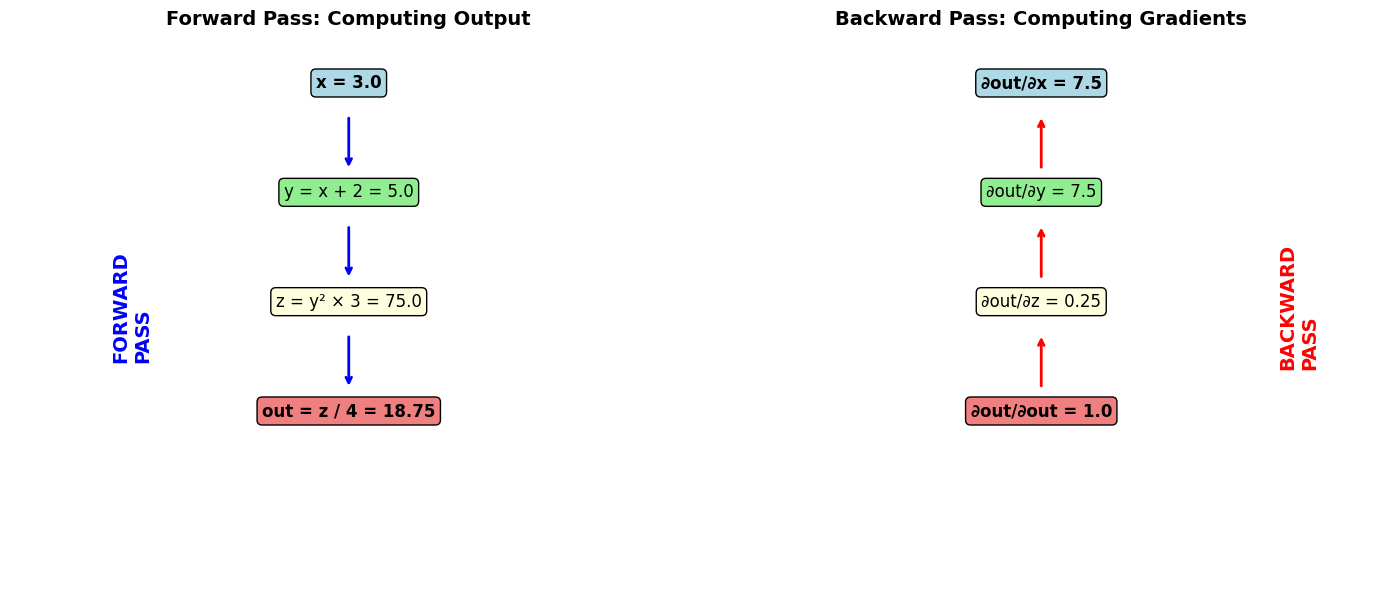

Final gradient ∂out/∂x = 7.5
This tells us: if x increases by 0.001, out increases by ~0.0075


In [5]:
# Visualize computation graph for: out = ((x + 2)^2 * 3) / 4
x_val = 3.0
x = torch.tensor(x_val, requires_grad=True)
y = x + 2
z = y * y * 3
out = z / 4

# Calculate gradient
out.backward()

# Create a visual representation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left plot: Forward pass with values
ax1.text(0.5, 0.9, f'x = {x_val}', bbox=dict(boxstyle='round', facecolor='lightblue'), 
         ha='center', fontsize=12, fontweight='bold')
ax1.annotate('', xy=(0.5, 0.75), xytext=(0.5, 0.85), 
             arrowprops=dict(arrowstyle='->', lw=2, color='blue'))
ax1.text(0.5, 0.7, f'y = x + 2 = {y.item()}', bbox=dict(boxstyle='round', facecolor='lightgreen'), 
         ha='center', fontsize=12)
ax1.annotate('', xy=(0.5, 0.55), xytext=(0.5, 0.65), 
             arrowprops=dict(arrowstyle='->', lw=2, color='blue'))
ax1.text(0.5, 0.5, f'z = y² × 3 = {z.item()}', bbox=dict(boxstyle='round', facecolor='lightyellow'), 
         ha='center', fontsize=12)
ax1.annotate('', xy=(0.5, 0.35), xytext=(0.5, 0.45), 
             arrowprops=dict(arrowstyle='->', lw=2, color='blue'))
ax1.text(0.5, 0.3, f'out = z / 4 = {out.item()}', bbox=dict(boxstyle='round', facecolor='lightcoral'), 
         ha='center', fontsize=12, fontweight='bold')

ax1.text(0.15, 0.5, 'FORWARD\nPASS', fontsize=14, fontweight='bold', 
         color='blue', rotation=90, va='center')
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.axis('off')
ax1.set_title('Forward Pass: Computing Output', fontsize=14, fontweight='bold')

# Right plot: Backward pass with gradients
ax2.text(0.5, 0.3, f'∂out/∂out = 1.0', bbox=dict(boxstyle='round', facecolor='lightcoral'), 
         ha='center', fontsize=12, fontweight='bold')
ax2.annotate('', xy=(0.5, 0.45), xytext=(0.5, 0.35), 
             arrowprops=dict(arrowstyle='->', lw=2, color='red'))
ax2.text(0.5, 0.5, f'∂out/∂z = 0.25', bbox=dict(boxstyle='round', facecolor='lightyellow'), 
         ha='center', fontsize=12)
ax2.annotate('', xy=(0.5, 0.65), xytext=(0.5, 0.55), 
             arrowprops=dict(arrowstyle='->', lw=2, color='red'))
ax2.text(0.5, 0.7, f'∂out/∂y = 7.5', bbox=dict(boxstyle='round', facecolor='lightgreen'), 
         ha='center', fontsize=12)
ax2.annotate('', xy=(0.5, 0.85), xytext=(0.5, 0.75), 
             arrowprops=dict(arrowstyle='->', lw=2, color='red'))
ax2.text(0.5, 0.9, f'∂out/∂x = {x.grad.item()}', bbox=dict(boxstyle='round', facecolor='lightblue'), 
         ha='center', fontsize=12, fontweight='bold')

ax2.text(0.85, 0.5, 'BACKWARD\nPASS', fontsize=14, fontweight='bold', 
         color='red', rotation=90, va='center')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.axis('off')
ax2.set_title('Backward Pass: Computing Gradients', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Final gradient ∂out/∂x = {x.grad.item()}")
print("This tells us: if x increases by 0.001, out increases by ~0.0075")

### Visualization: The Computation Graph

Let's visualize how PyTorch builds the computation graph and how gradients flow backward.

## Part 4: The Math (Sensitivity)

What does `x.grad = 4.5` actually mean?

It means **Sensitivity**.

If `x.grad` is 4.5, it means:
"If I increase `x` by a tiny amount (0.001), the output `y` will increase by **4.5 times** that amount."

$$ \frac{dy}{dx} \approx \frac{\Delta y}{\Delta x} $$

Let's prove this with code.

In [7]:
# Define a simple function y = x^2
def f(x):
    return x ** 2

x = torch.tensor(4.0, requires_grad=True)
y = f(x)
y.backward()
gradient = x.grad.item()

print(f"At x=4, the gradient is {gradient}")
print("This means if we nudge x by +0.001, y should change by approx 0.008 (8 * 0.001)")

# Let's verify manually
delta = 0.001
x_nudged = 4.0 + delta
y_nudged = x_nudged ** 2

y_original = 4.0 ** 2
actual_change = y_nudged - y_original
predicted_change = gradient * delta

print(f"Actual change in y:    {actual_change:.5f}")
print(f"Predicted change (8*d): {predicted_change:.5f}")
print("See? The gradient predicts how the output responds to input changes!")

At x=4, the gradient is 8.0
This means if we nudge x by +0.001, y should change by approx 0.008 (8 * 0.001)
Actual change in y:    0.00800
Predicted change (8*d): 0.00800
See? The gradient predicts how the output responds to input changes!


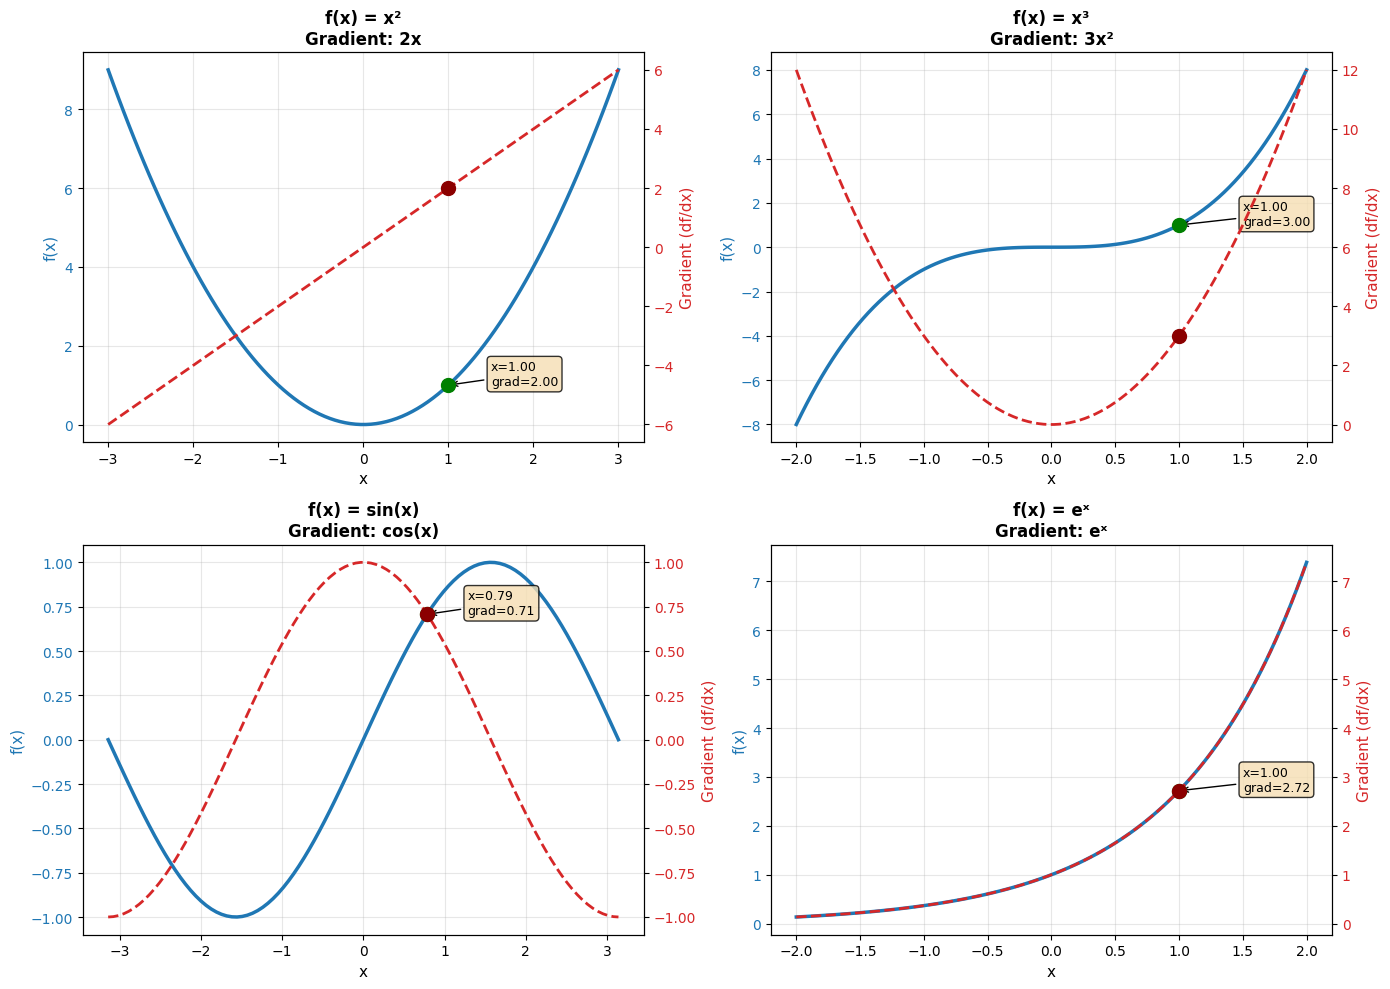

Key Insights:
• Blue solid line = Function output
• Red dashed line = Gradient (slope) at each point
• Green dot = Sample point where gradient is calculated
• Where gradient is HIGH, small changes in x cause BIG changes in output
• Where gradient is ZERO, the function is flat (local min/max)


In [8]:
# Visualize gradient as slope for different functions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

functions = [
    (lambda x: x**2, '2x', 'f(x) = x²'),
    (lambda x: x**3, '3x²', 'f(x) = x³'),
    (lambda x: torch.sin(x), 'cos(x)', 'f(x) = sin(x)'),
    (lambda x: torch.exp(x), 'eˣ', 'f(x) = eˣ')
]

x_ranges = [
    np.linspace(-3, 3, 100),
    np.linspace(-2, 2, 100),
    np.linspace(-np.pi, np.pi, 100),
    np.linspace(-2, 2, 100)
]

for idx, (func, grad_formula, title) in enumerate(functions):
    ax = axes[idx // 2, idx % 2]
    x_range = x_ranges[idx]
    
    # Compute function values
    x_tensor = torch.tensor(x_range, requires_grad=True, dtype=torch.float32)
    y_tensor = func(x_tensor)
    
    # Compute gradients
    gradients = []
    for i in range(len(x_range)):
        x_single = torch.tensor(x_range[i], requires_grad=True, dtype=torch.float32)
        y_single = func(x_single)
        y_single.backward()
        gradients.append(x_single.grad.item())
    
    # Plot function
    ax_func = ax
    color = 'tab:blue'
    ax_func.set_xlabel('x', fontsize=11)
    ax_func.set_ylabel('f(x)', color=color, fontsize=11)
    ax_func.plot(x_range, y_tensor.detach().numpy(), color=color, linewidth=2.5, label='Function')
    ax_func.tick_params(axis='y', labelcolor=color)
    ax_func.grid(True, alpha=0.3)
    
    # Plot gradient on secondary y-axis
    ax_grad = ax_func.twinx()
    color = 'tab:red'
    ax_grad.set_ylabel('Gradient (df/dx)', color=color, fontsize=11)
    ax_grad.plot(x_range, gradients, color=color, linewidth=2, linestyle='--', label='Gradient')
    ax_grad.tick_params(axis='y', labelcolor=color)
    
    # Mark a specific point
    test_point = 1.0 if idx != 2 else np.pi/4
    x_test = torch.tensor(test_point, requires_grad=True, dtype=torch.float32)
    y_test = func(x_test)
    y_test.backward()
    grad_test = x_test.grad.item()
    
    ax_func.scatter([test_point], [y_test.item()], color='green', s=100, zorder=5)
    ax_grad.scatter([test_point], [grad_test], color='darkred', s=100, zorder=5)
    
    ax_func.set_title(f'{title}\nGradient: {grad_formula}', fontsize=12, fontweight='bold')
    
    # Add annotation for the test point
    ax_func.annotate(f'x={test_point:.2f}\ngrad={grad_test:.2f}', 
                    xy=(test_point, y_test.item()), 
                    xytext=(test_point + 0.5, y_test.item()),
                    fontsize=9, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                    arrowprops=dict(arrowstyle='->', color='black'))

plt.tight_layout()
plt.show()

print("Key Insights:")
print("• Blue solid line = Function output")
print("• Red dashed line = Gradient (slope) at each point")
print("• Green dot = Sample point where gradient is calculated")
print("• Where gradient is HIGH, small changes in x cause BIG changes in output")
print("• Where gradient is ZERO, the function is flat (local min/max)")

### Visualization: Understanding Gradient as Sensitivity

Let's visualize how gradients represent the sensitivity of the output to input changes.

## Part 5: The "Gotcha" - Accumulating Gradients

This is the #1 bug for beginners.

PyTorch **accumulates** (adds) gradients by default. It doesn't replace them. This is useful for RNNs, but bad for standard training.

**ALWAYS zero your gradients before the next step.**

In [9]:
weights = torch.ones(2, requires_grad=True)

for i in range(3):
    loss = (weights * 3).sum()
    loss.backward()
    print(f"Step {i}, Gradients: {weights.grad}")
    
    # If we don't zero them, they just keep growing!
    # Uncomment the line below to fix it:
    # weights.grad.zero_()

Step 0, Gradients: tensor([3., 3.])
Step 1, Gradients: tensor([6., 6.])
Step 2, Gradients: tensor([9., 9.])


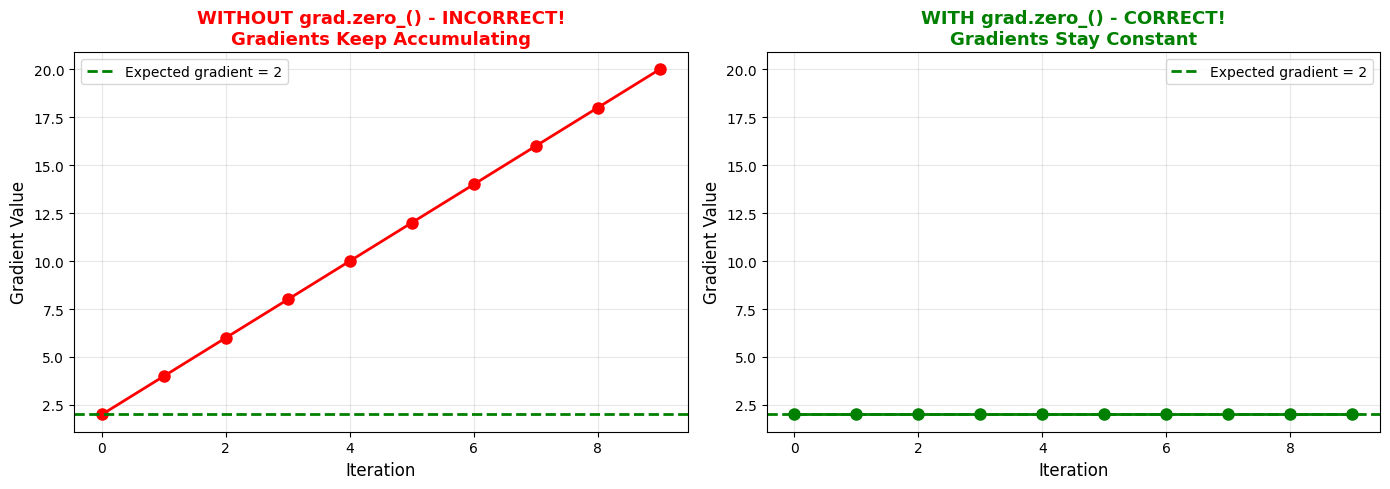

Remember: ALWAYS call .zero_() on gradients before backward() in training loops!
Without zeroing: gradients grow from 2.0 to 20.0
With zeroing: gradients stay constant at 2.0


In [10]:
# Compare gradient accumulation vs. proper zeroing
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Scenario 1: WITHOUT zeroing gradients (BUG!)
weights_no_zero = torch.ones(1, requires_grad=True)
grads_no_zero = []

for i in range(10):
    loss = (weights_no_zero * 2).sum()
    loss.backward()
    grads_no_zero.append(weights_no_zero.grad.item())
    # NOT zeroing gradients - they accumulate!

ax1.plot(range(10), grads_no_zero, marker='o', linewidth=2, markersize=8, color='red')
ax1.set_xlabel('Iteration', fontsize=12)
ax1.set_ylabel('Gradient Value', fontsize=12)
ax1.set_title('WITHOUT grad.zero_() - INCORRECT!\nGradients Keep Accumulating', 
              fontsize=13, fontweight='bold', color='red')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=2, color='green', linestyle='--', linewidth=2, label='Expected gradient = 2')
ax1.legend()

# Scenario 2: WITH zeroing gradients (CORRECT!)
weights_with_zero = torch.ones(1, requires_grad=True)
grads_with_zero = []

for i in range(10):
    if weights_with_zero.grad is not None:
        weights_with_zero.grad.zero_()  # Zero gradients before backward!
    
    loss = (weights_with_zero * 2).sum()
    loss.backward()
    grads_with_zero.append(weights_with_zero.grad.item())

ax2.plot(range(10), grads_with_zero, marker='o', linewidth=2, markersize=8, color='green')
ax2.set_xlabel('Iteration', fontsize=12)
ax2.set_ylabel('Gradient Value', fontsize=12)
ax2.set_title('WITH grad.zero_() - CORRECT!\nGradients Stay Constant', 
              fontsize=13, fontweight='bold', color='green')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=2, color='green', linestyle='--', linewidth=2, label='Expected gradient = 2')
ax2.legend()
ax2.set_ylim(ax1.get_ylim())  # Same scale for comparison

plt.tight_layout()
plt.show()

print("Remember: ALWAYS call .zero_() on gradients before backward() in training loops!")
print(f"Without zeroing: gradients grow from {grads_no_zero[0]} to {grads_no_zero[-1]}")
print(f"With zeroing: gradients stay constant at {grads_with_zero[0]}")

### Visualization: Gradient Accumulation Problem

Let's visualize what happens when we forget to zero gradients.

## Part 6: Advanced Autograd Concepts (FAANG Interview Essentials)

### torch.no_grad() vs torch.inference_mode() - Know the Difference!

Both disable gradient computation, but they have different use cases:

- **torch.no_grad()**: Disables gradient tracking. Use during validation/inference.
- **torch.inference_mode()** (PyTorch 1.9+): Even faster, stricter. Best for deployment.
- **requires_grad=False**: Permanent setting on a tensor.

In [ ]:
# torch.no_grad() vs torch.inference_mode() Demo
import time

x = torch.randn(1000, 1000, requires_grad=True)

# Method 1: torch.no_grad()
with torch.no_grad():
    y = x * 2
    print(f"With no_grad(): y.requires_grad = {y.requires_grad}")
    # Note: y is a "normal" tensor, can be used in grad computation later

# Method 2: torch.inference_mode() - Faster!
with torch.inference_mode():
    y = x * 2
    print(f"With inference_mode(): y.requires_grad = {y.requires_grad}")
    # Note: y is an "inference tensor", cannot be used in grad computation

# Performance comparison
def benchmark(context_fn, name, iterations=100):
    x = torch.randn(1000, 1000)
    start = time.time()
    for _ in range(iterations):
        with context_fn():
            y = x @ x  # Matrix multiplication
    elapsed = time.time() - start
    return elapsed

time_no_grad = benchmark(torch.no_grad, "no_grad")
time_inference = benchmark(torch.inference_mode, "inference_mode")

print(f"\nPerformance (100 iterations of 1000x1000 matmul):")
print(f"  torch.no_grad():       {time_no_grad:.4f}s")
print(f"  torch.inference_mode(): {time_inference:.4f}s")
print(f"  Speedup: {time_no_grad/time_inference:.2f}x")

print("\n🔑 FAANG Tip: Use inference_mode() in production for maximum speed!")

### .detach() - Breaking the Computation Graph

When you need to "stop" gradient flow at a specific point (common in GANs, RL, knowledge distillation):

- `.detach()` creates a new tensor that shares data but has no gradient connection
- Essential for preventing gradients from flowing to parts you don't want to update

In [ ]:
# .detach() Demo - Breaking the Graph

# Scenario: You want to compute loss but freeze some computations
x = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
y = x * 2  # y depends on x

# Without detach - gradients flow through
z1 = y.sum()
z1.backward()
print(f"Without detach: x.grad = {x.grad}")

# Reset
x.grad.zero_()

# With detach - gradients stop here
y_detached = y.detach()  # Same values, no gradient connection
z2 = y_detached.sum()
# z2.backward()  # This would error! y_detached has no grad_fn

print(f"y_detached.requires_grad = {y_detached.requires_grad}")
print(f"y_detached.grad_fn = {y_detached.grad_fn}")

# Real-world use case: GAN training
print("\n--- GAN Training Pattern ---")

# Fake generator and discriminator outputs
generator_output = torch.randn(4, requires_grad=True)
discriminator_input = generator_output.detach()  # Stop gradients to generator!

# Now discriminator trains on this, but generator weights won't be affected
fake_loss = discriminator_input.sum()
# fake_loss.backward()  # This only updates discriminator, not generator

print("In GAN training, we detach generator outputs when training discriminator")
print("This prevents gradients from 'leaking' into the generator")

print("\n🔑 FAANG Tip: detach() is critical for multi-network training (GANs, Actor-Critic RL)")

### retain_graph and Gradient Checkpointing

**retain_graph=True**: Keep computation graph after backward (for multiple backward passes)

**Gradient Checkpointing**: Trade compute for memory - recompute activations instead of storing them

In [ ]:
# retain_graph Demo

x = torch.tensor([1.0, 2.0], requires_grad=True)
y = x * 2
z = y.sum()

# First backward - normally, graph is destroyed after this
z.backward(retain_graph=True)
print(f"After 1st backward: x.grad = {x.grad}")

# Second backward - works because we retained the graph!
x.grad.zero_()
z.backward(retain_graph=True)
print(f"After 2nd backward: x.grad = {x.grad}")

# When is this useful?
print("\n--- Use Cases for retain_graph ---")
print("1. Multiple losses computed from same forward pass")
print("2. Higher-order gradients (gradients of gradients)")
print("3. Debugging/visualization of gradients")

# Gradient Checkpointing - Memory Optimization
print("\n--- Gradient Checkpointing ---")
from torch.utils.checkpoint import checkpoint

class BigModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Linear(100, 100)
        self.layer2 = torch.nn.Linear(100, 100)
        self.layer3 = torch.nn.Linear(100, 100)
    
    def forward(self, x):
        # Without checkpointing - stores all activations
        # x = self.layer1(x)
        # x = self.layer2(x)
        # x = self.layer3(x)
        
        # With checkpointing - recomputes layer1 and layer2 during backward
        x = checkpoint(self.layer1, x, use_reentrant=False)
        x = checkpoint(self.layer2, x, use_reentrant=False)
        x = self.layer3(x)
        return x

model = BigModel()
x = torch.randn(32, 100)
y = model(x)
print(f"Output shape: {y.shape}")
print("Checkpointing reduces memory at cost of ~30% more compute time")

print("\n🔑 FAANG Tip: Checkpointing is essential for training large models on limited GPU memory!")

### Custom Autograd Functions - Writing Your Own Backward Pass

Sometimes PyTorch's built-in operations aren't enough. You can define custom forward AND backward passes.

In [ ]:
# Custom Autograd Function - FAANG Interview Classic

class MyReLU(torch.autograd.Function):
    """
    Custom ReLU implementation showing how backward pass works.
    Forward: max(0, x)
    Backward: 1 if x > 0, else 0
    """
    
    @staticmethod
    def forward(ctx, input):
        """
        ctx: context object for saving tensors for backward
        """
        ctx.save_for_backward(input)  # Save for use in backward
        return input.clamp(min=0)
    
    @staticmethod
    def backward(ctx, grad_output):
        """
        grad_output: gradient flowing from the next layer
        Returns: gradient to flow to the previous layer
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input < 0] = 0  # Zero gradient where input was negative
        return grad_input

# Use our custom function
x = torch.tensor([-2.0, -1.0, 0.0, 1.0, 2.0], requires_grad=True)
y = MyReLU.apply(x)  # Use .apply() to call custom functions
loss = y.sum()
loss.backward()

print("Custom ReLU Demo:")
print(f"Input x:    {x.data}")
print(f"Output y:   {y.data}")
print(f"Gradients:  {x.grad}")
print("\nNote: gradients are 0 where input was negative (no gradient flow)")

# Straight-Through Estimator (STE) - Used in quantization
class StraightThroughEstimator(torch.autograd.Function):
    """
    Forward: Round to nearest integer
    Backward: Pass gradient unchanged (as if identity)
    
    Used for training quantized neural networks!
    """
    
    @staticmethod
    def forward(ctx, input):
        return input.round()
    
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output  # Gradient passes through unchanged

x = torch.tensor([0.3, 0.7, 1.2, 1.8, 2.5], requires_grad=True)
y = StraightThroughEstimator.apply(x)
loss = y.sum()
loss.backward()

print("\nStraight-Through Estimator (for quantization):")
print(f"Input:     {x.data}")
print(f"Rounded:   {y.data}")
print(f"Gradients: {x.grad}")
print("Gradients flow through even though forward is non-differentiable!")

print("\n🔑 FAANG Tip: Custom autograd is used in quantization, Gumbel-Softmax, and RL policy gradients!")

## Part 7: FAANG Interview Questions - Autograd & Gradients

### Question 1: "Explain the chain rule and how backpropagation uses it"

**Answer**:
The chain rule states: if y = f(g(x)), then dy/dx = (dy/dg) * (dg/dx)

Backpropagation applies this recursively through the computation graph:
1. Start from the loss (output)
2. Compute gradient of loss w.r.t. each intermediate activation
3. Multiply by the local gradient at each node
4. Accumulate gradients flowing to each parameter

```python
# Example: y = (x + 2)^2
# dy/dx = d/dx[(x+2)^2] = 2(x+2) * d/dx[x+2] = 2(x+2) * 1 = 2(x+2)
```

### Question 2: "What's the vanishing gradient problem and how do you address it?"

**Answer**:
**Problem**: In deep networks, gradients can become exponentially small as they propagate backward, causing early layers to learn very slowly.

**Causes**:
- Sigmoid/tanh activations saturate, giving near-zero gradients
- Very deep networks multiply many small numbers

**Solutions**:
1. **ReLU activation**: Gradient is 1 or 0, doesn't saturate
2. **Residual connections**: Skip connections allow gradients to flow directly
3. **Batch normalization**: Normalizes activations, prevents saturation
4. **Careful initialization**: Xavier/He initialization
5. **Gradient clipping**: Caps gradient magnitude

### Question 3: "What's the difference between .backward() and torch.autograd.grad()?"

**Answer**:
```python
# .backward() - populates .grad attributes on leaf tensors
x = torch.tensor([1.0], requires_grad=True)
y = x ** 2
y.backward()
print(x.grad)  # tensor([2.])

# torch.autograd.grad() - returns gradients directly, doesn't modify .grad
x = torch.tensor([1.0], requires_grad=True)
y = x ** 2
grad = torch.autograd.grad(y, x)  # Returns tuple of gradients
print(grad[0])  # tensor([2.])
```

Use `torch.autograd.grad()` when:
- You need higher-order derivatives
- You want gradients w.r.t. non-leaf tensors
- You're doing meta-learning (MAML)

### Question 4: "How does PyTorch handle in-place operations with autograd?"

**Answer**:
In-place operations (e.g., `x.add_(1)`) can break autograd because:
1. They overwrite values needed for backward pass
2. The computation graph references the old values

PyTorch tracks a `_version` counter on each tensor. If a tensor is modified in-place after being part of a computation, backward() will raise an error.

```python
x = torch.tensor([1.0], requires_grad=True)
y = x * 2
x.data.add_(1)  # Bypass version check (DANGEROUS!)
y.backward()  # May give wrong gradients!
```

**Best Practice**: Never use in-place operations on tensors that are part of the computation graph.

### Question 5: "Explain gradient accumulation and when you'd use it"

**Answer**:
Gradient accumulation = summing gradients across multiple forward passes before updating weights.

```python
accumulation_steps = 4
optimizer.zero_grad()

for i, (inputs, targets) in enumerate(dataloader):
    outputs = model(inputs)
    loss = criterion(outputs, targets) / accumulation_steps
    loss.backward()  # Gradients accumulate!
    
    if (i + 1) % accumulation_steps == 0:
        optimizer.step()
        optimizer.zero_grad()
```

**Use Cases**:
1. Simulate larger batch sizes on limited GPU memory
2. Training with batch size 32 on a GPU that only fits batch size 8
3. Required for training very large models (LLMs)

## Summary: Autograd Mastery Checklist

### Foundation (Know These Cold)
- [ ] Loss Function = measure of model error (lower is better)
- [ ] Learning Rate = step size for parameter updates
- [ ] Gradient = direction and magnitude of steepest ascent
- [ ] Gradient Descent = update in opposite direction of gradient

### Mechanics (Interview Essentials)
- [ ] `requires_grad=True` enables gradient tracking
- [ ] `.backward()` computes gradients via chain rule
- [ ] `.grad` stores computed gradients (accumulated by default!)
- [ ] `.zero_()` clears gradients between steps

### Advanced Topics (FAANG Level)
- [ ] `torch.no_grad()` vs `torch.inference_mode()` - inference contexts
- [ ] `.detach()` - break computation graph (GANs, RL)
- [ ] `retain_graph=True` - keep graph for multiple backward passes
- [ ] Gradient checkpointing - trade compute for memory
- [ ] Custom autograd functions - define forward and backward passes

### Common Pitfalls
- [ ] Forgetting to zero gradients (accumulation bug)
- [ ] In-place operations breaking the graph
- [ ] Vanishing/exploding gradients in deep networks
- [ ] Device mismatches (CPU tensor in GPU computation)

---
**Next**: Notebook 02 - Building Neural Networks (nn.Module architecture)